# Credit Card Fraud Detection Using SMOTE

This is the 2nd approach I'm sharing for credit card fraud detection. Refer to my earlier kernel @ https://www.kaggle.com/hrao768/gaussian-distrib-for-anomaly-detection-f1-83

We are going to explore resampling techniques like oversampling in this 2nd approach. Here are the key steps involved in this kernel.

    1) Balance the dataset by oversampling fraud class records using SMOTE
    
    2) Train the model using oversampled data by Random Forest
    
    3) Evaluate the performance of this model based on predictions on original imbalanced test data
        
    4) Add cluster segments to the original train and test data using K-Means algorithm
    
    5) Repeat the steps 1, 2 & 3 and see if the performance of Random Forest has improved by adding clusters
    
    6) Finally evaluate our model performance and check if it can generalize well on the unseen data using K-fold cross validation on original train data
    

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,cross_val_predict,cross_val_score, GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import confusion_matrix,classification_report,f1_score,recall_score,precision_score,accuracy_score,precision_recall_curve,roc_curve,roc_auc_score

from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE

from collections import Counter

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import warnings
warnings.filterwarnings('ignore')

import random
random.seed(0)

In [70]:
def data_preparation(data):
    features = data.iloc[:,0:-1]
    label = data.iloc[:,-1]
    x_train,x_test,y_train,y_test = train_test_split(features,label,test_size=0.2,random_state=0)

    #Standarad scaler is not applied since all the features are outcomes of PCA and are already standardized.
    #sc = StandardScaler()
    #x_train = sc.fit_transform(x_train)
    #x_test = sc.transform(x_test)
    
    print("Length of training data",len(x_train))
    print("Length of test data",len(x_test))
    return x_train,x_test,y_train,y_test
    

In [71]:
def build_model_train_test(model,x_train,x_test,y_train,y_test):
    model.fit(x_train,y_train)

    y_pred = model.predict(x_train)
    
    print("\n----------Accuracy Scores on Train data------------------------------------")
    print("F1 Score: ", f1_score(y_train,y_pred))
    print("Precision Score: ", precision_score(y_train,y_pred))
    print("Recall Score: ", recall_score(y_train,y_pred))


    print("\n----------Accuracy Scores on Test data------------------------------------")
    y_pred_test = model.predict(x_test)
    
    print("F1 Score: ", f1_score(y_test,y_pred_test))
    print("Precision Score: ", precision_score(y_test,y_pred_test))
    print("Recall Score: ", recall_score(y_test,y_pred_test))

    #Confusion Matrix
    plt.figure(figsize=(18,6))
    gs = gridspec.GridSpec(1,2)

    ax1 = plt.subplot(gs[0])
    cnf_matrix = confusion_matrix(y_train,y_pred)
    row_sum = cnf_matrix.sum(axis=1,keepdims=True)
    cnf_matrix_norm =cnf_matrix / row_sum
    sns.heatmap(cnf_matrix_norm,cmap='YlGnBu',annot=True)
    plt.title("Normalized Confusion Matrix - Train Data")

    ax2 = plt.subplot(gs[1])
    cnf_matrix = confusion_matrix(y_test,y_pred_test)
    row_sum = cnf_matrix.sum(axis=1,keepdims=True)
    cnf_matrix_norm =cnf_matrix / row_sum
    sns.heatmap(cnf_matrix_norm,cmap='YlGnBu',annot=True)
    plt.title("Normalized Confusion Matrix - Test Data")


In [72]:
#Loading Dataset
cc_dataset = pd.read_csv("D:/HRao/TechDocs/DataScience/MLPython_DataJango/Notes/data/creditcard.csv")

In [73]:
cc_dataset.shape

(284807, 31)

In [74]:
cc_dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [75]:
cc_dataset.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [76]:
#Code for checking if any feature has null values. Here the output confirms that there are no null values in this data set.
cc_dataset.isnull().any()

Time      False
V1        False
V2        False
V3        False
V4        False
V5        False
V6        False
V7        False
V8        False
V9        False
V10       False
V11       False
V12       False
V13       False
V14       False
V15       False
V16       False
V17       False
V18       False
V19       False
V20       False
V21       False
V22       False
V23       False
V24       False
V25       False
V26       False
V27       False
V28       False
Amount    False
Class     False
dtype: bool

In [77]:
#Counts for each class in the dataset. As you can see, we have only 492 (0.17%) fraud cases out of 284807 records. Remaining 284315 (99.8%) of the records belong to genuine cases.
#So the dataset is clearly imbalanced!
cc_dataset['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

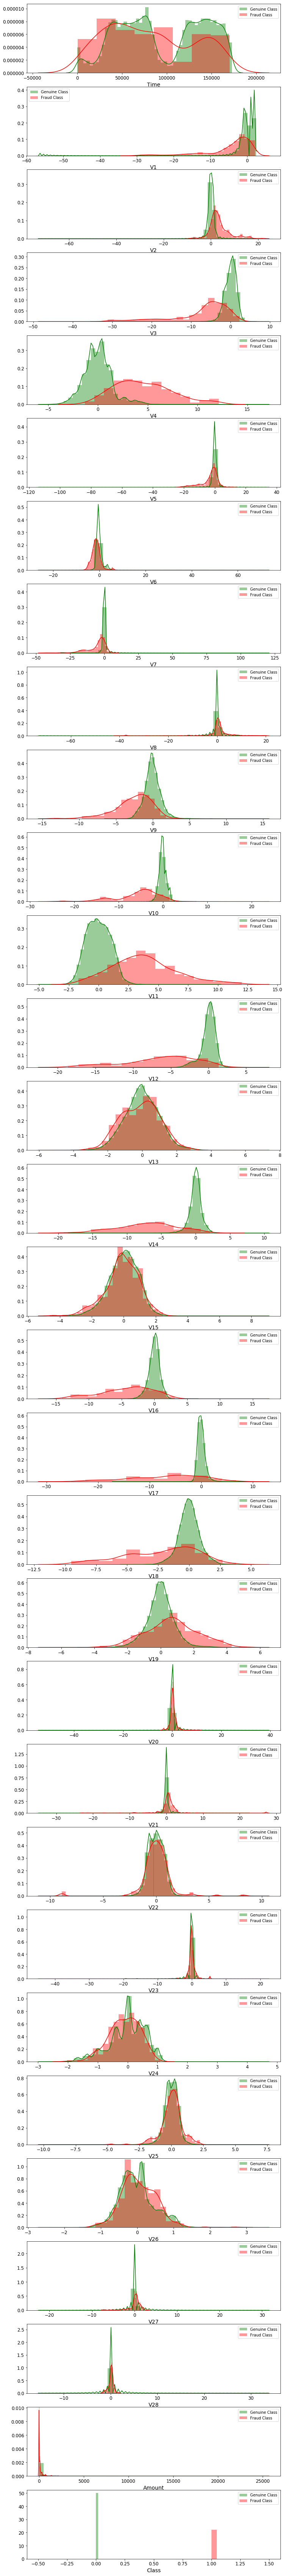

In [78]:
#Data Visualization for checking the distribution for Genuine cases & Fraud cases for each feature
v_features = cc_dataset.columns
plt.figure(figsize=(12,31*4))
gs = gridspec.GridSpec(31,1)

for i, col in enumerate(v_features):
    ax = plt.subplot(gs[i])
    sns.distplot(cc_dataset[col][cc_dataset['Class']==0],color='g',label='Genuine Class')
    sns.distplot(cc_dataset[col][cc_dataset['Class']==1],color='r',label='Fraud Class')
    ax.legend()
plt.show()

Feature selection: 
    1) We can see distribution of anomalous transactions (class = 1) is matching with distribution of genuine transactions (class = 0) for V28','V27','V26','V25','V24','V23','V22','V20','V15','V13','V8' features. It is better to delete these features as they may not be useful in finding anomalous records.
    2) Time is also not useful variable since it contains the seconds elapsed between the transaction for that record and the first transaction in the dataset. So the data is in increasing order always.
    
Let us remove the feature 'Time' for now and build the model.

In [79]:
cc_dataset.drop(labels = ['Time'], axis = 1, inplace=True)

The feature 'Amount' has higher standard deviation of 250, which indicate the spread is very high & also we might have outliers in the data. So let us go for feature scaling for Amount variable using StandardScaler().

In [80]:
cc_dataset['Amount'] = StandardScaler().fit_transform(cc_dataset['Amount'].reshape(-1,1))

In [81]:
#Data Preparation
x_train,x_test,y_train,y_test = data_preparation(cc_dataset)

Length of training data 227845
Length of test data 56962


imbalanced-learn is a python package offering a number of re-sampling techniques commonly used in datasets showing strong between-class imbalance. It is compatible with scikit-learn and is part of scikit-learn-contrib projects.

imbalanced-learn is currently available on the PyPi's repository and you can install it via pip: pip install -U imbalanced-learn

I'm going to use Synthetic Minority Oversampling Technique (SMOTE) to balance the dataset here.

In [82]:
os = SMOTE(random_state=0)

In [83]:
#Generate the oversample data
os_res_x,os_res_y=os.fit_sample(x_train,y_train)
#Counts of each class in oversampled data
print(sorted(Counter(os_res_y).items()))

[(0, 227454), (1, 227454)]


We can see that fraud records are imputed and brought close to genuine records in this oversampled data using SMOTE. Hence both classes are equally distributed now.


----------Accuracy Scores on Train data------------------------------------
F1 Score:  1.0
Precision Score:  1.0
Recall Score:  1.0

----------Accuracy Scores on Test data------------------------------------
F1 Score:  0.8527918781725888
Precision Score:  0.875
Recall Score:  0.8316831683168316


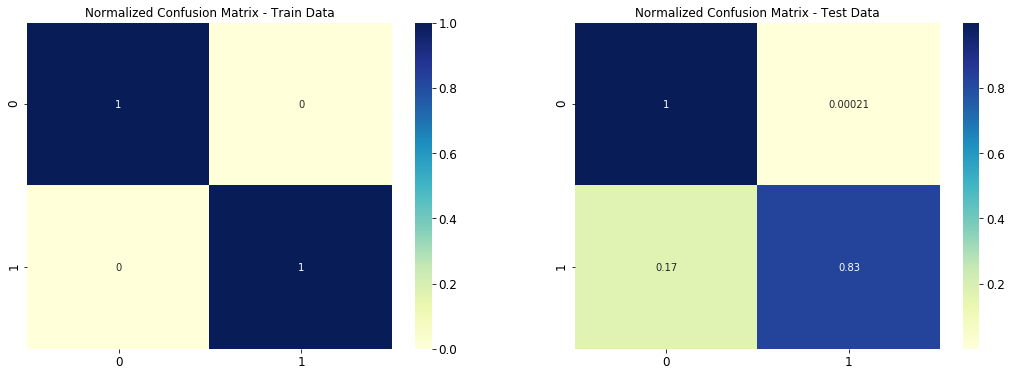

In [84]:
#RandomForest for training over-sampled data set. 
rnd_clf = RandomForestClassifier(n_estimators=100,criterion='gini',n_jobs=-1, random_state=0)
#Train the model on oversampled data and check the performance on original test data
build_model_train_test(rnd_clf,os_res_x,x_test,os_res_y,y_test)

RandomForest has given good results after balancing the training data using synthetic over-sampling approach: F1 score of 85 on orignal test data (without oversmapling)

I'd like to try K-means clustering to identify the clusters in the dataset, which could improve the predictive power in fraud detection.

In [85]:
# #Elbow Curve for identifying the best number of clusters
# wcss = [] # Within Cluster Sum of Squares
# for k in range(1, 21):
#     kmeans = KMeans(n_clusters = k, init = 'k-means++', random_state = 0)
#     kmeans.fit(x_train)
#     wcss.append(kmeans.inertia_)
# plt.plot(range(1, 21), wcss)
# plt.title('The Elbow Method')
# plt.xlabel('Number of clusters - k')
# plt.ylabel('WCSS')
# plt.show()

In [86]:
#Clustering with 11 clusters. I used the elbow method to derive on number of clusters. I commented the above code to save the run time
kmeans_best = KMeans(n_clusters = 11, init = 'k-means++', random_state = 0)
train_clusters = kmeans_best.fit_predict(x_train)

In [87]:
#Merge clusters with other input features on Train Data
x_train2 = np.c_[(x_train,train_clusters )]
x_train2.shape

(227845, 30)

In [88]:
#Predict the cluster for test data & merge it with other features
test_clusters = kmeans_best.predict(x_test)
x_test2 = np.c_[(x_test,test_clusters )]
x_test2.shape

(56962, 30)

In [89]:
#Generate the oversample data for training purpose
os_res_x2,os_res_y2=os.fit_sample(x_train2,y_train)
#Counts of each class in oversampled data
print(sorted(Counter(os_res_y2).items()))


[(0, 227454), (1, 227454)]



----------Accuracy Scores on Train data------------------------------------
F1 Score:  1.0
Precision Score:  1.0
Recall Score:  1.0

----------Accuracy Scores on Test data------------------------------------
F1 Score:  0.8686868686868687
Precision Score:  0.8865979381443299
Recall Score:  0.8514851485148515


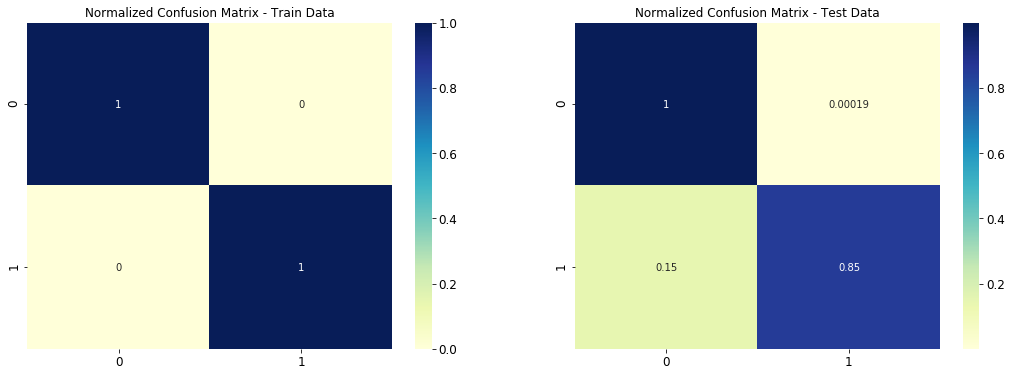

In [90]:
#RandomForest for training over-sampled data set. 
rnd_clf2 = RandomForestClassifier(n_estimators=100,criterion='gini',n_jobs=-1, random_state=0)
#Train the model on oversampled data and check the performance on actual test data
build_model_train_test(rnd_clf2,os_res_x2,x_test2,os_res_y2,y_test)


Post adding the clusters to the dataset, the performance of RandomForest model has improved little bit: F1 score of 87 and recall score of 85 on the orignal test data (without oversmapling).
Let us check the consistency of this model by using cross validation scores based on the original train data.

In [91]:
#Let us check cross validation scores on the orginal train data
cv_score = cross_val_score(rnd_clf2,x_train2,y_train,cv=5,scoring='f1')
print("Average F1 score CV",cv_score.mean())


Average F1 score CV 0.8456711783117072


In [92]:
cv_score = cross_val_score(rnd_clf2,x_train2,y_train,cv=5,scoring='recall')
print("Average Recall score CV",cv_score.mean())


Average Recall score CV 0.7724115546900358


On the cross validation, recall score has gone down little bit. However overall F1-score is still around 85. So we can go ahead with this model.

Conclusion: In general, oversampling techniques like SMOTE should provide better results than normal supervised learning algorithms on imbalanced datasets. We added clustering over the top of SMOTE to identify the patterns better and it has given best results on this dataset.